In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from torch.distributions import constraints
import pyro.optim as optim
import os
import pandas as pd
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
pyro.enable_validation(True)
pyro.set_rng_seed(1)

In [2]:
%matplotlib inline
plt.style.use('default')

# Poisson Regression Example: 

## Predicting number of visitors to minigolf course
### Independent Variables: 
- temperature
- raining

### Dependent Variable: 
- number of visitors

## First, we define our model and corresponding guide.

### We will need a link funciton for Poisson regression (ReLU chosen here, but another could be used)

In [3]:
def link(x):
#     return torch.exp(x) # this explodes the gradient! Maybe there is a way to get around this?
#     return torch.abs(x) + 1 # this can make the coefficients harder to interpret (either like linear or *-1)
    return torch.nn.ReLU()(x) + 1 # this does not explode the gradient and gives somewhat interpretable coefs

In [4]:
# x is a 2D tensor with dimensions num_variables x num_samples
# y is a 1D tensor with dimensions num_samples
# link is the link function
# b_locs (optionally) specifies means of the weights (including bias weight)
# b_locs (optionally) specifies variances of the weights (including bias weight)
def model(x, y, link, b_locs=None, b_scales=None):
    num_weights = x.shape[0] + 1
    
    # if unspecified, set b_locs and b_scales to correspond to std normal dist.
    if b_locs is None:
        b_locs = torch.zeros(num_weights)
    if b_scales is None:
        b_scales = torch.ones(num_weights)
    
    b = torch.empty(num_weights)
    # sample weights
    for i in range(num_weights):
        b[i] = pyro.sample(f"b{i}", dist.Normal(b_locs[i], b_scales[i]))
    
    linear_mean = b[0] + torch.matmul(b[1:], x)
    
    # The link function to tranform from R to R_{>0}
    lmda = link(linear_mean)
    
    num_obs = x.shape[1]
    with pyro.plate("data", num_obs):
        pyro.sample("obs", dist.Poisson(lmda), obs=y)

In [5]:
# x is a 2D tensor with dimensions num_variables x num_samples
# y is a 1D tensor with dimensions num_samples
# link is the link function
# b_locs (optionally) specifies means of the weights (including bias weight)
# b_locs (optionally) specifies variances of the weights (including bias weight)
def guide(x, y, link, b_locs=None, b_scales=None):
    num_weights = x.shape[0] + 1
    
    # if unspecified, set b_locs and b_scales to correspond to std normal dist.
    
    if b_locs is None:
        b_locs = torch.zeros(num_weights)
    if b_scales is None:
        b_scales = torch.ones(num_weights)
    
    # make the weight scale and locs into pyro params
    b_loc_params = torch.empty(num_weights)
    b_scale_params = torch.empty(num_weights)
    
    for i in range(num_weights):
        b_loc_params[i] = pyro.param(f'b_{i}_loc', b_locs[i])
        b_scale_params[i] = pyro.param(f'b_{i}_scale', b_scales[i], constraint=constraints.positive)
    
    # sample weights
    b = torch.empty(num_weights)
    
    for i in range(num_weights):
        b[i] = pyro.sample(f"b{i}", dist.Normal(b_loc_params[i], b_scale_params[i]))
    
    linear_mean = b[0] + torch.matmul(b[1:], x)
    
    # The link function to tranform from R to R_{>0}
    lmda = link(linear_mean)

## An example of some hard-coded dummy data (values are purely out of some human intuition)

(Used initally, but not now. Ultimately favored genertive model to see how they perform on an actual poisson distribution)

In [6]:
x = torch.tensor([[60., 75., 76., 77., 80., 82., 63., 65., 70., 71., 72., 73.], # temps
                  [1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.]]) # rainings
y = torch.tensor( [2.,  30., 35., 5.,  25., 6.,  4.,  4.,  29., 32., 40., 38.]) # visitor_counts

## Instead of dummy data, try sampling from acutal distributions!

In [7]:

def generate_data(b, link, n_samples):
    # initialize the weights
    b_0 = b[0]
    b_t = b[1]
    b_r = b[2]
    
    x = torch.empty((2, n_samples))
    y = torch.empty(n_samples)
    
    for i in range(n_samples):

        # sample the independent variable values
        temp = pyro.sample("temp", dist.Normal(70., 10.)) # temperature normall distributed
        raining = pyro.sample("raining", dist.Bernoulli(0.2)) # only rain 20% of the time

        linear_mean = b_0 + b_t * temp + b_r * raining

        lmda = link(linear_mean)

        visitor_count = pyro.sample("visitor_count", dist.Poisson(lmda))
        
        x[0,i] = temp
        x[1,i] = raining
        y[i] = visitor_count
    
    return x, y

In [8]:

b = [10, 0.2, -20] # some reasonable weights! people like minigolfing when its warm and not rainy.
num_samples = 365 # say we have a year's worth of data (in an extremely temperate climate!)
x, y = generate_data(b, link, num_samples)

## Will use summary func from http://pyro.ai/examples/bayesian_regression_ii.html to give idea of coefficient distribution

In [9]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Now, we'll use SVI and MCMC to find the distributions of the regression coefficients (again like in http://pyro.ai/examples/bayesian_regression_ii.html)

## First, we'll find the regression coeffients through SVI

In [11]:
svi = SVI(model,
          guide,
          optim.Adam({"lr": .01}),
          loss=Trace_ELBO())

pyro.clear_param_store()
num_iters = 10000
for i in range(num_iters):
    elbo = svi.step(x, y, link, b_scales=torch.tensor([10., 1., 10.]))
    if i % 1000 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 17923.439453125
Elbo loss: 1430.2422433495522
Elbo loss: 1264.7032657265663
Elbo loss: 1072.475319802761
Elbo loss: 1056.3708093166351
Elbo loss: 1064.1888600885868
Elbo loss: 1094.1855271458626
Elbo loss: 1056.127563893795
Elbo loss: 1064.5821886062622
Elbo loss: 1048.6141452789307


In [12]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(x, y, link).items()
               if k != "obs"}

In [13]:
for site, values in summary(svi_samples).items():
    print("Coefficient: {}".format(site))
    print(values, "\n")

Coefficient: b0
       mean       std        5%       25%       50%       75%      95%
0  6.266294  0.221023  5.906303  6.116541  6.269057  6.414338  6.62462 

Coefficient: b1
       mean       std        5%       25%       50%       75%      95%
0  0.255301  0.004287  0.248412  0.252273  0.255294  0.258323  0.26269 

Coefficient: b2
        mean       std         5%        25%        50%       75%        95%
0 -19.616056  0.246058 -20.018683 -19.782851 -19.612788 -19.44684 -19.215271 



## Next, we'll find the regression coeffients through MCMC

In [14]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=250)
mcmc.run(x, y, link, b_scales=torch.tensor([10., 1., 10.]))

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 2250/2250 [02:32, 14.77it/s, step size=4.76e-02, acc. prob=0.912]


In [15]:
for site, values in summary(hmc_samples).items():
    print("Coefficient: {}".format(site))
    print(values, "\n")

Coefficient: b0
       mean       std        5%       25%       50%       75%        95%
0  8.742924  1.248655  6.577571  7.866087  8.852208  9.653236  10.699399 

Coefficient: b1
       mean       std        5%       25%       50%      75%       95%
0  0.221926  0.017687  0.193609  0.209356  0.220958  0.23493  0.252122 

Coefficient: b2
        mean       std         5%        25%        50%        75%        95%
0 -19.863363  0.409516 -20.523254 -20.122965 -19.865728 -19.584757 -19.194681 



# Finally, we visualize the distributions of the coefficients vs. the true (generating) value of the coefficients.

/Users/marcusdaly/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marcusdaly/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marcusdaly/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an expli

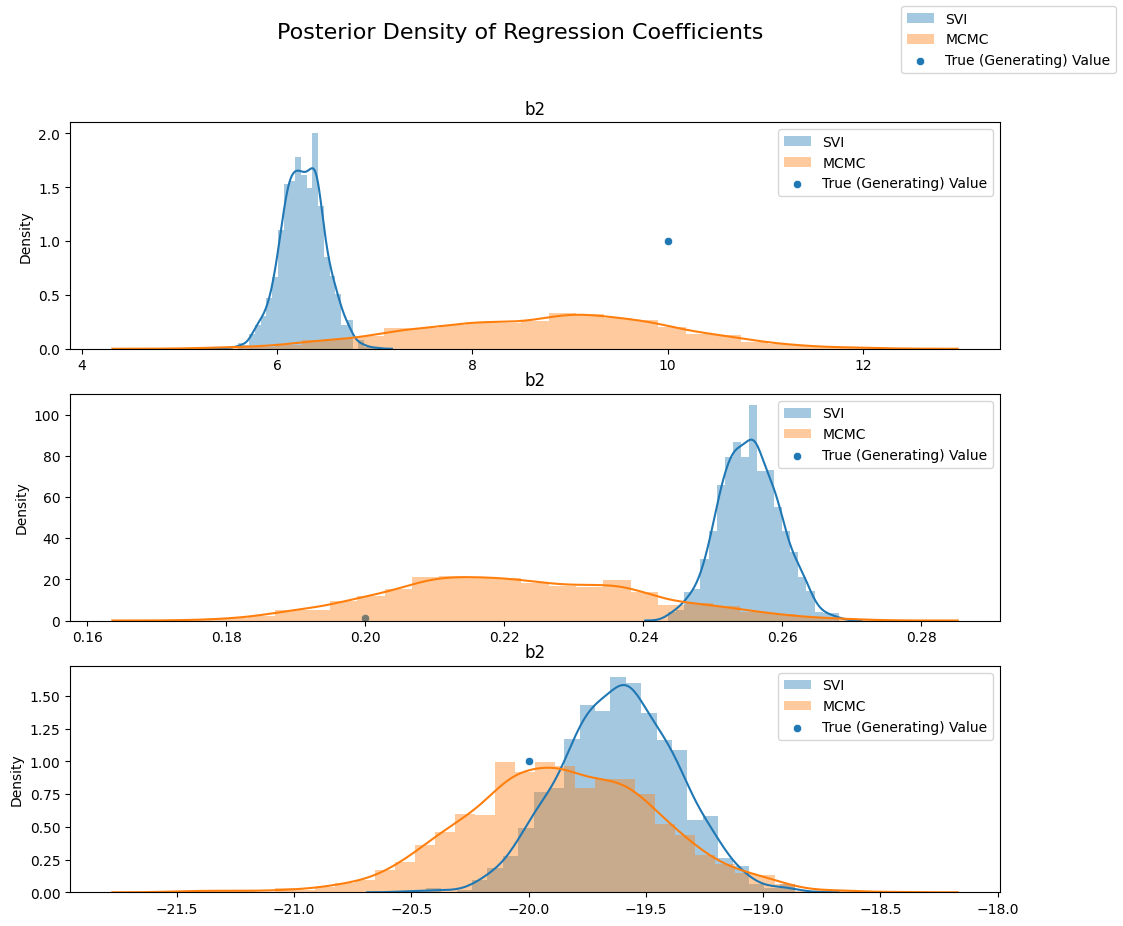

In [16]:
coefs = ["b0", "b1", "b2"]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
fig.suptitle("Posterior Density of Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    coef = coefs[i]
    weight = b[i]
    sns.distplot(svi_samples[coef], ax=ax, label="SVI")
    sns.distplot(hmc_samples[coef], ax=ax, label="MCMC")
    sns.scatterplot([weight], [1], ax=ax, label="True (Generating) Value")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');